#import modules

In [ ]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from google.colab import drive


In [ ]:
drive.mount('/content/gdrive', force_remount=True)
%cd /content/gdrive/MyDrive/Uni/Arshad/NeuralNetwork/HW6/Q1/Dataset

Mounted at /content/gdrive
/content/gdrive/MyDrive/Uni/Arshad/NeuralNetwork/HW6/Q1/Dataset


In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 100
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

#read dataset

In [ ]:
dataset = np.zeros((5*201,32,32))
index=0
for i in range(5):
  for j in range(201): 
    img = np.array(mpimg.imread(f'Class {i+1}/{j}.png'))
    dataset[index] = img
    index= index +1

show sample image

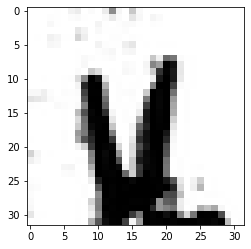

In [ ]:
plt.imshow(dataset[201],  cmap='Greys', interpolation='nearest')

shuffle and batching dataset

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#Model

generator model

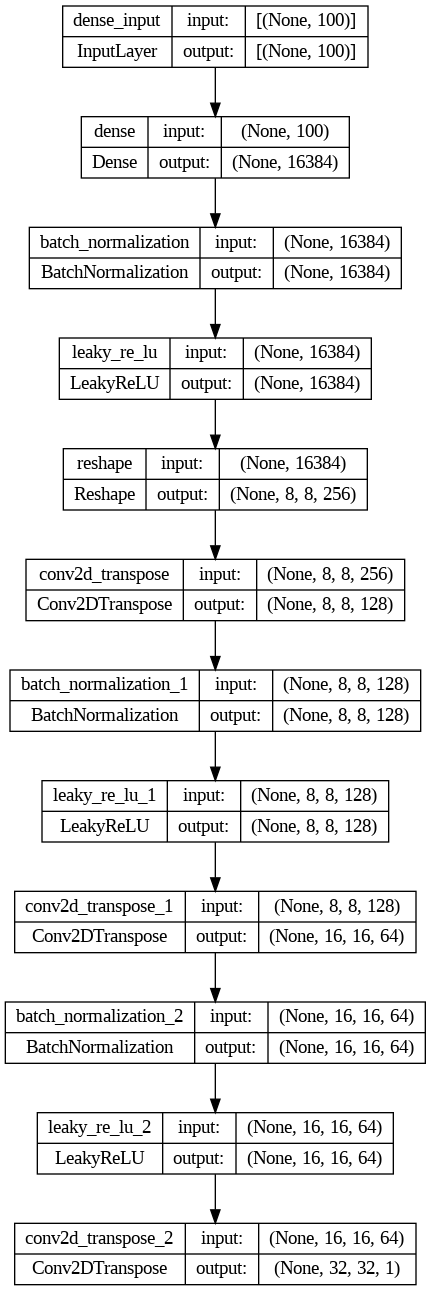

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256) 

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 1)

    return model

generator = make_generator_model()
tf.keras.utils.plot_model(generator, "generator Architecture.png", show_shapes=True)

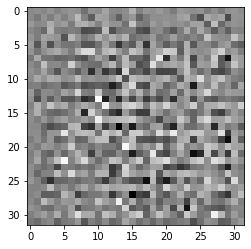

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

discriminator model

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[32, 32, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.GaussianNoise(0.1))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, "sigmoid"))

    return model

tf.Tensor([[0.5002597]], shape=(1, 1), dtype=float32)


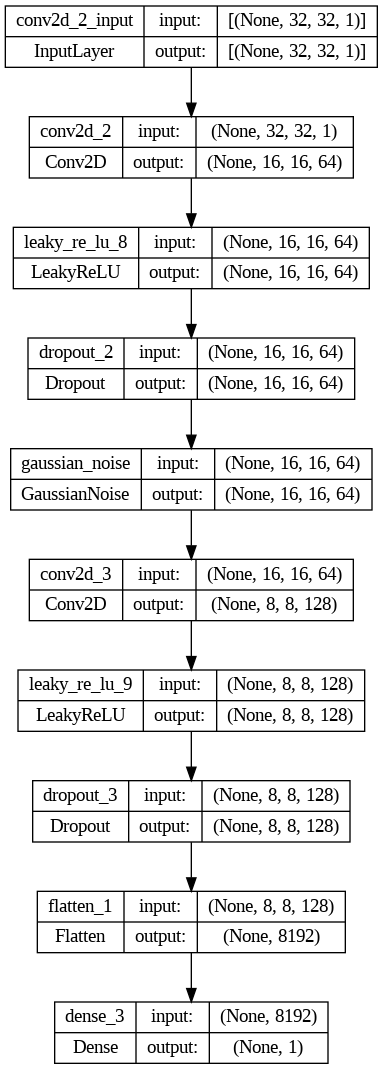

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)
tf.keras.utils.plot_model(discriminator, "generator Architecture.png", show_shapes=True)

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) * 0.9, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

#     calculate accuracy
      acc = 0
      for i in range(len(real_output)):
        if real_output[i] >= 0.5:
          acc = acc + 1
      for i in range(len(fake_output)):
        if fake_output[i] < 0.5:
          acc = acc + 1
      acc = acc / (len(real_output) + len(fake_output))


      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss, acc

In [ ]:
def show_img(predictions):
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.show()

In [ ]:
def train(dataset, epochs):
  gen_loss_per_epoch = []
  disc_loss_per_epoch = []
  acc_per_epoch = []

  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      gen_loss, disc_loss, acc = train_step(image_batch)
    print(f"epoch {epoch}- generator loss: {gen_loss}, discriminator loss: {disc_loss},  accuracy: {acc}")
    gen_loss_per_epoch.append(gen_loss)
    disc_loss_per_epoch.append(disc_loss)
    acc_per_epoch.append(acc) 

    if epoch % 10 == 0 :
      predictions = generator(seed, training=False)
      show_img(predictions)

  return gen_loss_per_epoch, disc_loss_per_epoch, acc_per_epoch

epoch 0- generator loss: 1.7026000022888184, discriminator loss: 0.6616419553756714,  accuracy: 0.9523809523809524


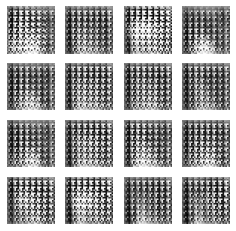

epoch 1- generator loss: 1.6356396675109863, discriminator loss: 0.5611467361450195,  accuracy: 0.9714285714285715
epoch 2- generator loss: 1.2861523628234863, discriminator loss: 0.8208144903182983,  accuracy: 0.7904761904761906
epoch 3- generator loss: 1.0656851530075073, discriminator loss: 1.2613191604614258,  accuracy: 0.6190476190476191
epoch 4- generator loss: 1.0773009061813354, discriminator loss: 1.0125341415405273,  accuracy: 0.6857142857142857
epoch 5- generator loss: 1.151990532875061, discriminator loss: 0.8913023471832275,  accuracy: 0.8285714285714286
epoch 6- generator loss: 1.276313304901123, discriminator loss: 0.6908693313598633,  accuracy: 0.9523809523809524
epoch 7- generator loss: 1.0411685705184937, discriminator loss: 1.2528599500656128,  accuracy: 0.7523809523809525
epoch 8- generator loss: 0.887462317943573, discriminator loss: 1.6288177967071533,  accuracy: 0.46666666666666673
epoch 9- generator loss: 0.9380443692207336, discriminator loss: 1.738423109054565

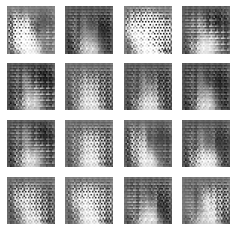

epoch 11- generator loss: 1.2084993124008179, discriminator loss: 0.8309487700462341,  accuracy: 0.7809523809523811
epoch 12- generator loss: 1.09385347366333, discriminator loss: 0.9922356009483337,  accuracy: 0.7047619047619048
epoch 13- generator loss: 0.8779556751251221, discriminator loss: 1.254941701889038,  accuracy: 0.6380952380952382
epoch 14- generator loss: 0.7995379567146301, discriminator loss: 1.5393846035003662,  accuracy: 0.5047619047619049
epoch 15- generator loss: 0.8248255252838135, discriminator loss: 1.0991592407226562,  accuracy: 0.6380952380952382
epoch 16- generator loss: 0.7638400197029114, discriminator loss: 1.227136254310608,  accuracy: 0.5142857142857143
epoch 17- generator loss: 0.834550678730011, discriminator loss: 1.3228919506072998,  accuracy: 0.5523809523809524
epoch 18- generator loss: 0.9440569281578064, discriminator loss: 1.0553967952728271,  accuracy: 0.6285714285714287
epoch 19- generator loss: 0.7646806836128235, discriminator loss: 1.315017223

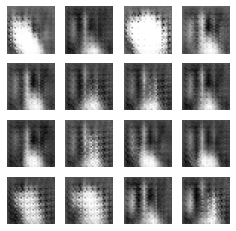

epoch 21- generator loss: 0.8269698619842529, discriminator loss: 1.3484885692596436,  accuracy: 0.5523809523809524
epoch 22- generator loss: 0.8429390788078308, discriminator loss: 1.297999620437622,  accuracy: 0.6190476190476191
epoch 23- generator loss: 0.882611870765686, discriminator loss: 1.511777400970459,  accuracy: 0.6666666666666667
epoch 24- generator loss: 0.840192973613739, discriminator loss: 1.377284288406372,  accuracy: 0.6190476190476191
epoch 25- generator loss: 0.8356451392173767, discriminator loss: 1.3084437847137451,  accuracy: 0.6476190476190476
epoch 26- generator loss: 0.8918598294258118, discriminator loss: 1.2624680995941162,  accuracy: 0.6666666666666667
epoch 27- generator loss: 0.8462085127830505, discriminator loss: 1.2340445518493652,  accuracy: 0.6666666666666667
epoch 28- generator loss: 0.8728356957435608, discriminator loss: 1.1429100036621094,  accuracy: 0.6380952380952382
epoch 29- generator loss: 0.8645840287208557, discriminator loss: 1.064548969

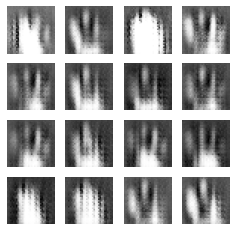

epoch 31- generator loss: 0.8348215222358704, discriminator loss: 1.2003633975982666,  accuracy: 0.6571428571428573
epoch 32- generator loss: 0.7578679919242859, discriminator loss: 1.3573009967803955,  accuracy: 0.5619047619047619
epoch 33- generator loss: 0.869869589805603, discriminator loss: 1.1354734897613525,  accuracy: 0.6761904761904762
epoch 34- generator loss: 0.8067963123321533, discriminator loss: 1.2166736125946045,  accuracy: 0.6000000000000001
epoch 35- generator loss: 0.6885176301002502, discriminator loss: 1.328953504562378,  accuracy: 0.4571428571428572
epoch 36- generator loss: 0.6534581780433655, discriminator loss: 1.4032683372497559,  accuracy: 0.4190476190476191
epoch 37- generator loss: 0.6924974322319031, discriminator loss: 1.46685791015625,  accuracy: 0.48571428571428577
epoch 38- generator loss: 0.7382158041000366, discriminator loss: 1.3564890623092651,  accuracy: 0.5047619047619049
epoch 39- generator loss: 0.7791292071342468, discriminator loss: 1.3237142

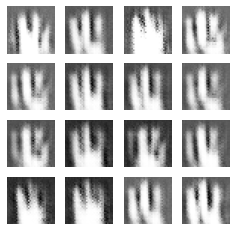

epoch 41- generator loss: 0.7747431993484497, discriminator loss: 1.6041734218597412,  accuracy: 0.5619047619047619
epoch 42- generator loss: 0.7762439846992493, discriminator loss: 1.4872004985809326,  accuracy: 0.6000000000000001
epoch 43- generator loss: 0.7995728254318237, discriminator loss: 1.1767123937606812,  accuracy: 0.6476190476190476
epoch 44- generator loss: 0.7489564418792725, discriminator loss: 1.2233715057373047,  accuracy: 0.5904761904761905
epoch 45- generator loss: 0.7520327568054199, discriminator loss: 1.3411304950714111,  accuracy: 0.5714285714285715
epoch 46- generator loss: 0.7720573544502258, discriminator loss: 1.4800081253051758,  accuracy: 0.5428571428571429
epoch 47- generator loss: 0.8027236461639404, discriminator loss: 1.2866125106811523,  accuracy: 0.6666666666666667
epoch 48- generator loss: 0.8078544735908508, discriminator loss: 1.1840217113494873,  accuracy: 0.6952380952380953
epoch 49- generator loss: 0.7424834966659546, discriminator loss: 1.3978

In [ ]:
gen_loss_per_epoch, disc_loss_per_epoch, acc_per_epoch = train(train_dataset, EPOCHS)

In [ ]:
predictions = generator(seed, training=False)

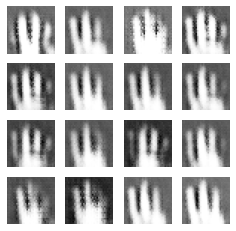

In [ ]:
fig = plt.figure(figsize=(4, 4))

for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

plt.show()

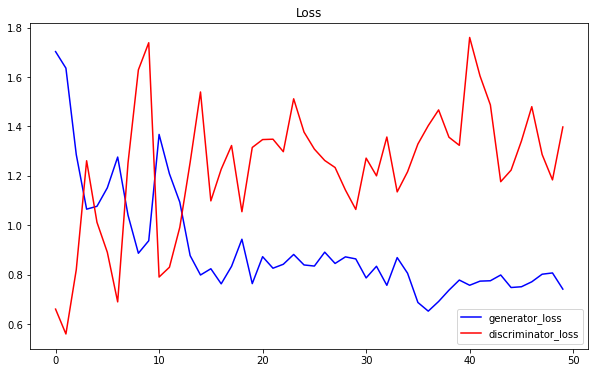

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(gen_loss_per_epoch, color = 'blue', label = 'generator_loss')
plt.plot(disc_loss_per_epoch, color = 'red', label = 'discriminator_loss')
plt.legend()
plt.title('Loss')
plt.show()

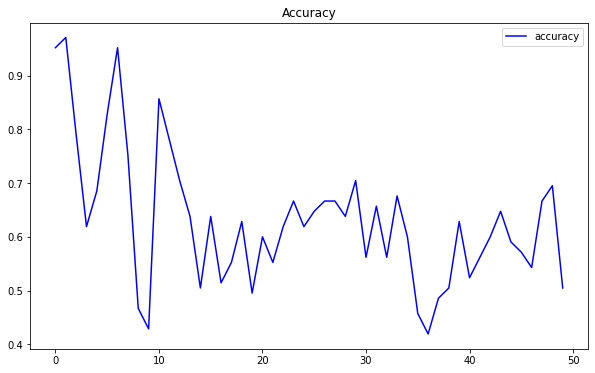

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(acc_per_epoch, color = 'blue', label = 'accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()